# CPM Predictor 2

Following code from https://github.com/YaleMRRC/CPM/tree/master

In [4]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import spearmanr, t, ttest_1samp, pearsonr
from sklearn.linear_model import LinearRegression
from statsmodels.robust.robust_linear_model import RLM

import json
from joblib import dump

In [5]:
node_size=100
def compute_correlation(fmri):
    # Calculate the z_score (along the time axis)
    fmri_zscored = (fmri.T - fmri.mean(axis=1)) / fmri.std(axis=1)

    # Calculate the FC 
    fc = np.corrcoef(fmri_zscored.T)
    
    return fc

In [6]:
threshold = 0.05
def train_cpm(ipmat, pheno):

    """
    Accepts input matrices and pheno data
    Returns model
    @author: David O'Connor
    @documentation: Javid Dadashkarimi
    cpm: in cpm we select the most significant edges for subjects. so each subject
         have a pair set of edges with positive and negative correlation with behavioral subjects.
         It's important to keep both set in final regression task.  
    posedges: positive edges are a set of edges have positive
              correlatin with behavioral measures
    negedges: negative edges are a set of edges have negative
              correlation with behavioral measures
    """
    cc=[spearmanr(pheno,im) for im in ipmat]
    
    rmat=np.array([c[0] for c in cc])
    pmat=np.array([c[1] for c in cc])
    rmat=np.reshape(rmat,[100,100])
    pmat=np.reshape(pmat,[100,100])
    posedges=(rmat > 0) & (pmat < threshold)    # edges correalated with higher ADAS Scores
    posedges=posedges.astype(int)
    negedges=(rmat < 0) & (pmat < threshold)    # edges correalated with lower ADAS Scores
    negedges=negedges.astype(int)
    pe=ipmat[posedges.flatten().astype(bool),:]
    ne=ipmat[negedges.flatten().astype(bool),:]
    pe=pe.sum(axis=0)/2
    ne=ne.sum(axis=0)/2


    if np.sum(pe) != 0:
        fit_pos=np.polyfit(pe,pheno,1)      # fit a curve through the positive edges
    else:
        fit_pos=[]

    if np.sum(ne) != 0:
        fit_neg=np.polyfit(ne,pheno,1)       # fit a curve through the negative edges
    else:
        fit_neg=[]

    return fit_pos,fit_neg,posedges,negedges

def run_validate(X,y,cvtype):
    """
    Accepts input matrices (X), phenotype data (y), and the type of cross-valdiation (cv_type)    
    Returns the R-values for positive model (Rpos), negative model (Rneg), and the combination
    X: the feature matrix of size (number of nodes x number of nodes x number of subjects)
    y: the phenotype vector of size (number of subjects)
    cv_type: the cross-valdiation type, takes one of the followings: 
    1) LOO: leave-one-out cross-validation
    2) 5k: 
    """
    numsubs=X.shape[2]
    X=np.reshape(X,[-1,numsubs])
    
    if cvtype == 'LOO':
        behav_pred_pos=np.zeros([numsubs])
        behav_pred_neg=np.zeros([numsubs])
        for loo in range(0,numsubs):

            print("Running LOO, sub no:",loo)
      
            train_mats=np.delete(X,[loo],axis=1)
            train_pheno=np.delete(y,[loo],axis=0)
            
            test_mat=X[:,loo]
            test_pheno=y[loo]

            pos_fit,neg_fit,posedges,negedges=train_cpm(train_mats,train_pheno)

            pe=np.sum(test_mat[posedges.flatten().astype(bool)])/2
            ne=np.sum(test_mat[negedges.flatten().astype(bool)])/2
            
            # Run model on test subject

            if len(pos_fit) > 0:
                behav_pred_pos[loo]=pos_fit[0]*pe + pos_fit[1]       # predict using the coefficients of the curve
            else:
                behav_pred_pos[loo]='nan'

            if len(neg_fit) > 0:
                behav_pred_neg[loo]=neg_fit[0]*ne + neg_fit[1]
            else:
                behav_pred_neg[loo]='nan'
          
        return behav_pred_pos, behav_pred_neg

        
#         Rpos=pearsonr(behav_pred_pos,y)[0]
#         Rneg=pearsonr(behav_pred_neg,y)[0]
        
#         return Rpos,Rneg
    

### Get Features (FC Matrices)

In [17]:
results = []

In [4]:
def normalise_correlate_fc(fmri):
    fc_emp = fmri / np.max(fmri)
    fc_emp = np.corrcoef(fc_emp)
    return fc_emp

In [7]:
# ADAS_DATA = '../data/ADAS_ADNIGO23_17Apr2024_FILTERED_wfiles_197.csv'
# PHC_DATA = '../data/ADSP_PHC_COGN_Dec2023_FILTERED_wfiles.csv'
ADNI_MERGE = '../data/ADNIMERGE/ADNIMERGE_29Apr2024_wFiles.csv'
df = pd.read_csv(ADNI_MERGE)
# df = df.drop(columns=['RID', 'VISCODE2', 'PHC_Diagnosis', 'PHC_EXF', 'PHC_LAN', 'PHC_VSP'])
df.head()

,Unnamed: 0,RID,COLPROT,ORIGPROT,PTID,SITE,VISCODE,EXAMDATE,DX_bl,AGE,...,FDG_bl,PIB_bl,AV45_bl,FBB_bl,Years_bl,Month_bl,Month,M,update_stamp,FC_DATA
0,49,5280,ADNI2,ADNI2,100_S_5280,100,M024,2015-09-29,SMC,67.5,...,1.19409,NaN,0.9851,NaN,2.03149,24.3279,24,24,2023-07-07 05:00:02.0,../FMRI_ADNI_DATA/fc/sub-ADNI100S5280_ses-M024...
1,659,5265,ADNI2,ADNI2,007_S_5265,7,M024,2015-08-25,SMC,75.1,...,1.28381,NaN,1.2359,NaN,2.03422,24.3607,24,24,2023-07-07 05:00:01.0,../FMRI_ADNI_DATA/fc/sub-ADNI007S5265_ses-M024...
2,702,5262,ADNI2,ADNI2,018_S_5262,18,M000,2013-09-03,SMC,73.5,...,NaN,NaN,NaN,NaN,0.00000,0.0000,0,0,2023-07-07 05:00:01.0,../FMRI_ADNI_DATA/fc/sub-ADNI018S5262_ses-M000...
3,1203,5250,ADNI2,ADNI2,018_S_5250,18,M000,2013-09-05,SMC,73.9,...,1.21422,NaN,1.0664,NaN,0.00000,0.0000,0,0,2023-07-07 05:00:01.0,../FMRI_ADNI_DATA/fc/sub-ADNI018S5250_ses-M000...
4,1446,5242,ADNI2,ADNI2,019_S_5242,19,M000,2013-07-11,SMC,67.2,...,1.29605,NaN,0.9090,NaN,0.00000,0.0000,0,0,2023-07-07 05:00:01.0,../FMRI_ADNI_DATA/fc/sub-ADNI019S5242_ses-M000...


In [ ]:
list(df.columns)

In [8]:
adni_df = df[['RID', 'VISCODE', 'ADAS11', 'PTEDUCAT', 'ADAS13', 'DX', 'DX_bl', 'FC_DATA']]
adni_df = adni_df.dropna(subset=['ADAS11'])

adni_df.shape

(1339, 8)

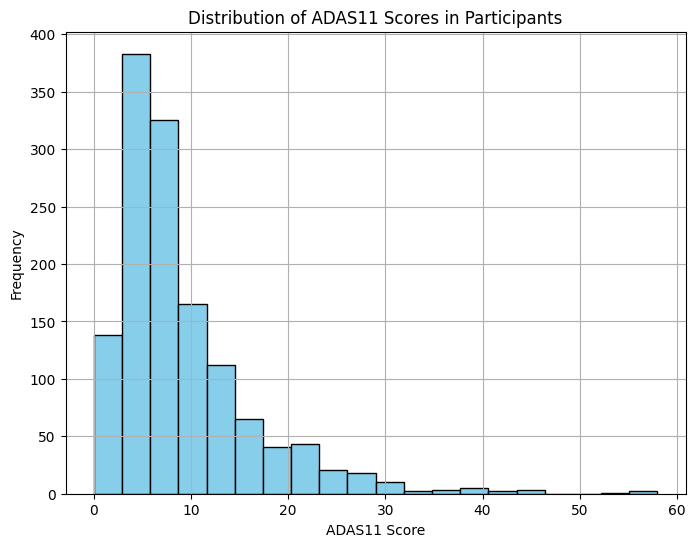

In [9]:
plt.figure(figsize=(8, 6))
plt.hist(adni_df['ADAS11'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of ADAS11 Scores in Participants')
plt.xlabel('ADAS11 Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.axis('on')
# plt.savefig('../data/adas11_score_dist_20bins.png')

plt.show()

In [10]:
grouped = adni_df.groupby('DX_bl')

# Accessing each group
for category, group in grouped:
    print("Category:", category)
    print(group.shape)

Category: AD
(100, 8)
Category: CN
(362, 8)
Category: EMCI
(302, 8)
Category: LMCI
(247, 8)
Category: SMC
(328, 8)


In [17]:
# STRATIFIED SAMPLING FROM EACH PATIENT GROUP

sample_df = None
total_sample = 0

for category, group in grouped:
    f = group.shape[0]
    sample_n = 1 if f * 0.05 < 1 else round(f * 0.05)
#     print(sample_n)

    random = group.sample(sample_n)
    sample_df = pd.concat([sample_df, random])

sample_df = sample_df.reset_index(drop=True)
print(sample_df.shape)

# EQUAL SAMPLING FROM EACH PATIENT GROUP
# Want a sample of size 100 from each bucket

sample_eq_df = None
sample_n = 100

for category, group in grouped:
    f = group.shape[0]
    bucket_n = sample_n if f > sample_n else f

    random = group.sample(bucket_n)
    sample_eq_df = pd.concat([sample_eq_df, random])

sample_eq_df = sample_eq_df.reset_index(drop=True)
print(sample_eq_df.shape)

(66, 8)
(500, 8)


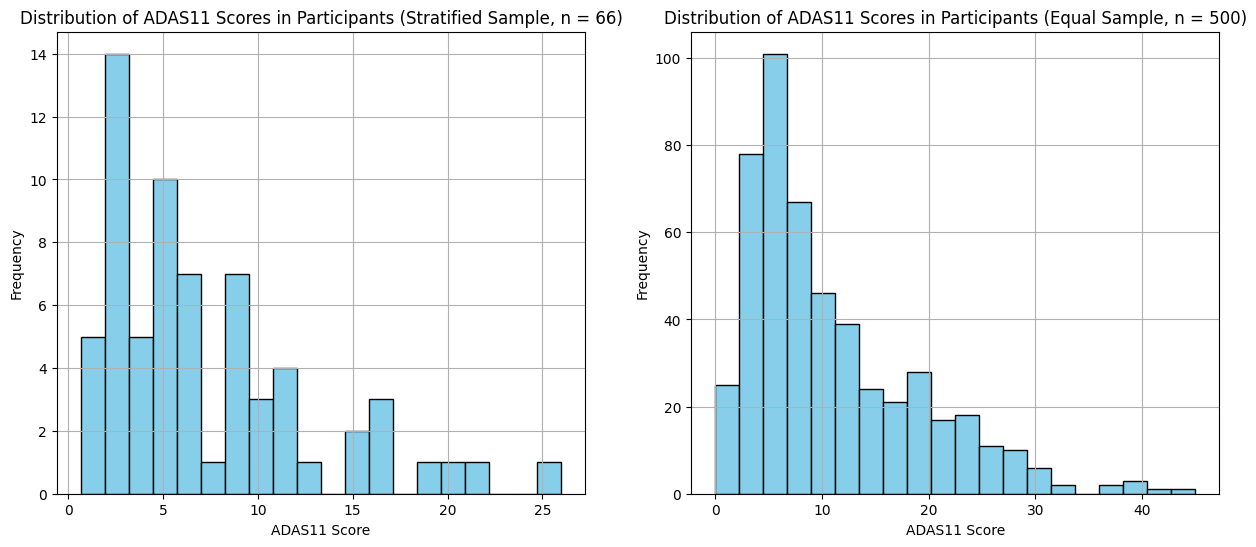

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].hist(sample_df['ADAS11'], bins=20, color='skyblue', edgecolor='black')
ax[0].set_title('Distribution of ADAS11 Scores in Participants (Stratified Sample, n = 66)')
ax[0].set_xlabel('ADAS11 Score')
ax[0].set_ylabel('Frequency')
ax[0].grid(True)
ax[0].axis('on')

ax[1].hist(sample_eq_df['ADAS11'], bins=20, color='skyblue', edgecolor='black')
ax[1].set_title('Distribution of ADAS11 Scores in Participants (Equal Sample, n = 500)')
ax[1].set_xlabel('ADAS11 Score')
ax[1].set_ylabel('Frequency')
ax[1].grid(True)
ax[1].axis('on')

plt.savefig('../data/adas11_score_sample_comp.png')

# plt.scatter(adni_df['PTEDUCAT'], adni_df['ADAS11'])
# sns.regplot(x='PTEDUCAT', y='ADAS11', data=adni_df, line_kws={'color':'red'})
# plt.xlabel('Education (Years)')  # Replace 'X Axis Label' with the label for your x-axis
# plt.ylabel('ADAS11 Cognitive Score')  # Replace 'Y Axis Label' with the label for your y-axis
# plt.title('Education (Years) against ADAS11 Cognitive Score')   # Replace 'Scatter Plot' with the title for your plot
# plt.savefig('../data/adas11_score_against_education.png')

plt.show()

In [21]:
dim_x = len(df)
X = []

for i, file in enumerate(sample_eq_df['FC_DATA'].values):
    arr = loadmat(f'../{file}')['ROI_activity'][:100, :] # get the first 100 regions
    fc = compute_correlation(arr)
    
    # Add noise along the diagonal
    noise_level = 0.0001  # Adjust this value as needed
    noise = np.random.randn(100) * noise_level
    fc_with_noise = fc + np.diag(noise)
    
    X.append(fc_with_noise)
X = np.array(X)

Y = sample_eq_df['ADAS11']
print(Y.shape)

X_eq_transposed = np.transpose(X, (1, 2, 0))
print(X_eq_transposed.shape)

(500,)
(100, 100, 500)


In [22]:
behav_pred_pos, behav_pred_neg = run_validate(X_eq_transposed, Y, 'LOO')

Running LOO, sub no: 0
Running LOO, sub no: 1
Running LOO, sub no: 2
Running LOO, sub no: 3
Running LOO, sub no: 4
Running LOO, sub no: 5
Running LOO, sub no: 6
Running LOO, sub no: 7
Running LOO, sub no: 8
Running LOO, sub no: 9
Running LOO, sub no: 10
Running LOO, sub no: 11
Running LOO, sub no: 12
Running LOO, sub no: 13
Running LOO, sub no: 14
Running LOO, sub no: 15
Running LOO, sub no: 16
Running LOO, sub no: 17
Running LOO, sub no: 18
Running LOO, sub no: 19
Running LOO, sub no: 20
Running LOO, sub no: 21
Running LOO, sub no: 22
Running LOO, sub no: 23
Running LOO, sub no: 24
Running LOO, sub no: 25
Running LOO, sub no: 26
Running LOO, sub no: 27
Running LOO, sub no: 28
Running LOO, sub no: 29
Running LOO, sub no: 30
Running LOO, sub no: 31
Running LOO, sub no: 32
Running LOO, sub no: 33
Running LOO, sub no: 34
Running LOO, sub no: 35
Running LOO, sub no: 36
Running LOO, sub no: 37
Running LOO, sub no: 38
Running LOO, sub no: 39
Running LOO, sub no: 40
Running LOO, sub no: 41
Ru

In [24]:
behav_pred_pos
res = {
#     'no_files': 134, 
    'noise': 0.0001, 
    'p_threshold': 0.01,
    'fc_gen_method': 'compute_correlation', 
    'sample_method': 'stratified',
    'pearson_r_pos': pearsonr(behav_pred_pos,Y)[0], 
    'pearson_r_neg': pearsonr(behav_pred_neg,Y)[0],
    'spearman_rho_pos': spearmanr(behav_pred_pos,Y, nan_policy='omit')[0], 
    'spearman_rho_neg': spearmanr(behav_pred_neg,Y, nan_policy='omit')[0], 
    'r2_pos': r2_score(Y, behav_pred_pos), 
    'r2_neg': r2_score(Y, behav_pred_neg), 
    'mse_pos': mean_squared_error(behav_pred_pos,Y),
    'mse_neg': mean_squared_error(behav_pred_neg,Y)
}
# results.append(res)

In [25]:
res

{'noise': 0.0001,
 'p_threshold': 0.01,
 'fc_gen_method': 'compute_correlation',
 'sample_method': 'stratified',
 'pearson_r_pos': 0.0776388468829477,
 'pearson_r_neg': 0.07123628153912245,
 'spearman_rho_pos': 0.09321467879121464,
 'spearman_rho_neg': 0.09179777380503013,
 'r2_pos': 0.002609046742818366,
 'r2_neg': 0.0020279764629165253,
 'mse_pos': 64.73255567680067,
 'mse_neg': 64.77026823487336}

In [38]:
results

[{'no_files': 66,
  'noise': 0.0001,
  'p_threshold': 0.05,
  'fc_gen_method': 'compute_correlation',
  'sample_method': 'stratified',
  'pearson_r_pos': 0.19429768976696976,
  'pearson_r_neg': -0.07140965598750981,
  'spearman_rho_pos': 0.12645353033336565,
  'spearman_rho_neg': -0.09444315219874633,
  'r2_pos': -5.617831230610038,
  'r2_neg': -10.537068237202183,
  'mse_pos': 47.85370729259691,
  'mse_neg': 54.80550807383122}]

In [23]:
results_df = pd.DataFrame(results)
results_df.head()

,no_files,noise,p_threshold,fc_gen_method,sample_method,pearson_r_pos,pearson_r_neg,spearman_rho_pos,spearman_rho_neg,r2_pos,r2_neg,mse_pos,mse_neg
0,66,0.0001,0.05,compute_correlation,stratified,0.194298,-0.07141,0.126454,-0.094443,-5.617831,-10.537068,47.853707,54.805508


In [24]:
results_df.to_csv('cpm_adas11_exp.csv')

# Old ADAS-Score stufff

In [6]:
# Get the FC data as numpy arrays
dim_x = len(df)
X = []

for i, file in enumerate(df['FC_DATA'].values[:50]):
    arr = loadmat(f'../{file}')['ROI_activity'][:100, :] # get the first 100 regions
    fc = normalise_correlate_fc(arr)
    
    # Add noise along the diagonal
    noise_level = 0.0001  # Adjust this value as needed
    noise = np.random.randn(100) * noise_level
    fc_with_noise = fc + np.diag(noise)
    
    X.append(fc_with_noise)

In [7]:
X = np.array(X)
X[0]

array([[ 0.99997386,  0.23786372,  0.20097916, ..., -0.05299774,
         0.39054918,  0.26728137],
       [ 0.23786372,  1.00003625,  0.73799572, ..., -0.48484301,
         0.30452082, -0.08258666],
       [ 0.20097916,  0.73799572,  1.0001053 , ..., -0.32228712,
         0.42146126,  0.18149275],
       ...,
       [-0.05299774, -0.48484301, -0.32228712, ...,  1.00004482,
         0.20001077,  0.5615397 ],
       [ 0.39054918,  0.30452082,  0.42146126, ...,  0.20001077,
         0.99987276,  0.73629405],
       [ 0.26728137, -0.08258666,  0.18149275, ...,  0.5615397 ,
         0.73629405,  0.99984811]])

In [93]:
Y = df['PHC_MEM'][:50]
Y.shape

(50,)

In [94]:
X.shape
X_transposed = np.transpose(X, (1, 2, 0))
X_transposed.shape

(100, 100, 50)

In [158]:
# results_df = pd.DataFrame(columns=['no_files', 'noise', 'fc_gen_method', 'pearson_r_pos', 'pearson_r_neg', 
#                                    'spearman_rho_pos', 'spearman_rho_neg', 'r2_pos', 'r2_neg', 'mse_pos',
#                                    'mse_neg'])
# results_df.head()

In [ ]:
behav_pred_pos, behav_pred_neg = run_validate(X_transposed, Y, 'LOO')

res = {
    'no_files': 50, 
    'noise': 0.0001, 
    'fc_gen_method': 'normalise_correlate_fc', 
    'pearson_r_pos': pearsonr(behav_pred_pos,Y)[0], 
    'pearson_r_neg': pearsonr(behav_pred_neg,Y)[0],
    'spearman_rho_pos': spearmanr(behav_pred_pos,Y)[0], 
    'spearman_rho_neg': spearmanr(behav_pred_neg,Y)[0], 
    'r2_pos': r2_score(behav_pred_pos,Y), 
    'r2_neg': r2_score(behav_pred_neg,Y), 
    'mse_pos': mean_squared_error(behav_pred_pos,Y),
    'mse_neg': mean_squared_error(behav_pred_neg,Y)
}

# results_df = pd.concat([results_df, pd.DataFrame([res])])

In [169]:
results_df.head()

,no_files,noise,fc_gen_method,pearson_r_pos,pearson_r_neg,spearman_rho_pos,spearman_rho_neg,r2_pos,r2_neg,mse_pos,mse_neg,2
0,100,0.0001,compute_correlation,0.012331,0.093077,-0.074421,0.123846,-7.925653,-9.484463,38.847254,36.210902,NaN
1,100,0.0001,normalise_correlate_fc,0.005774,0.043314,-0.082930,0.104430,-8.453046,-10.774776,38.761466,37.037568,NaN
2,50,0.0001,normalise_correlate_fc,0.186141,0.116007,0.134497,0.189920,-2.638026,-2.924703,23.157316,24.688216,NaN
0,50,0.0001,compute_correlation,0.252616,0.105604,0.138246,0.178816,-2.263829,-2.840129,21.754884,25.132758,NaN
0,40,0.0001,compute_correlation,0.112534,0.149578,0.057180,0.133703,-2.813653,-4.143540,21.521483,19.440756,NaN


In [170]:
results_df.to_csv('../data/cpm_experiments.csv')

In [139]:
# results_df = results_df.drop(results_df.index[-2:])

In [143]:
# results_df = results_df.reset_index(drop=True)

In [145]:
# results_df.loc[2, 'fc_gen_method'] = 'normalise_correlate_fc'

## Get Sample of Patients

In [8]:
# Define the number of buckets
n_buckets = 10

# Define the bins for splitting the column into buckets
bins = pd.cut(df['PHC_MEM'], bins=n_buckets, labels=False)

In [9]:
bins

0       7.0
1       7.0
2       6.0
3       7.0
4       7.0
       ... 
1337    4.0
1338    9.0
1339    7.0
1340    5.0
1341    6.0
Name: PHC_MEM, Length: 1342, dtype: float64

In [10]:
# Group the DataFrame by the bins and create a dictionary of DataFrames
buckets = {i: group for i, group in df.groupby(bins)}

In [11]:
for i in range(n_buckets):
    bucket = buckets.get(i)
    if bucket is not None:
        print(f"Bucket {i}:")
        print(bucket.shape)

Bucket 0:
(2, 3)
Bucket 1:
(10, 3)
Bucket 2:
(22, 3)
Bucket 3:
(84, 3)
Bucket 4:
(117, 3)
Bucket 5:
(262, 3)
Bucket 6:
(342, 3)
Bucket 7:
(324, 3)
Bucket 8:
(150, 3)
Bucket 9:
(28, 3)


### Stratified Sample

In [12]:
sample_df = None
total_sample = 0

for i in range(n_buckets):
    bucket = buckets.get(i)
    if bucket is not None:
        f = bucket.shape[0]
        sample_n = 1 if f * 0.1 < 1 else round(f * 0.1)
        print(sample_n)
        
        random = bucket.sample(sample_n)
        sample_df = pd.concat([sample_df, random])

sample_df = sample_df.reset_index(drop=True)
sample_df.shape

1
1
2
8
12
26
34
32
15
3


(134, 3)

In [14]:
sample_df

,Unnamed: 0,PHC_MEM,FC_DATA
0,229,-2.430,../FMRI_ADNI_DATA/fc/sub-ADNI127S0259_ses-M150...
1,2429,-2.029,../FMRI_ADNI_DATA/fc/sub-ADNI018S4696_ses-M006...
2,2644,-1.584,../FMRI_ADNI_DATA/fc/sub-ADNI126S4891_ses-M120...
3,1796,-1.418,../FMRI_ADNI_DATA/fc/sub-ADNI009S4324_ses-M090...
4,3844,-1.094,../FMRI_ADNI_DATA/fc/sub-ADNI027S6733_ses-M000...
...,...,...,...
129,2338,1.684,../FMRI_ADNI_DATA/fc/sub-ADNI007S4620_ses-M024...
130,1586,1.465,../FMRI_ADNI_DATA/fc/sub-ADNI002S4213_ses-M072...
131,1881,2.104,../FMRI_ADNI_DATA/fc/sub-ADNI029S4384_ses-M072...
132,2292,2.019,../FMRI_ADNI_DATA/fc/sub-ADNI031S4590_ses-M006...


In [35]:
dim_x = len(sample_df)
X_strat = []

for i, file in enumerate(sample_df['FC_DATA'].values):
    arr = loadmat(f'../{file}')['ROI_activity'][:100, :] # get the first 100 regions
    fc = compute_correlation(arr)
    
    # Add noise along the diagonal
    noise_level = 0.0001  # Adjust this value as needed
    noise = np.random.randn(100) * noise_level
    fc_with_noise = fc + np.diag(noise)
    
    X_strat.append(fc_with_noise)
X_strat = np.array(X_strat)

In [36]:
Y_strat = sample_df['PHC_MEM']
print(Y_strat.shape)

X_strat_transposed = np.transpose(X_strat, (1, 2, 0))
print(X_strat_transposed.shape)

(134,)
(100, 100, 134)


In [37]:
behav_pred_pos, behav_pred_neg = run_validate(X_strat_transposed, Y_strat, 'LOO')

Running LOO, sub no: 0
Running LOO, sub no: 1
Running LOO, sub no: 2
Running LOO, sub no: 3
Running LOO, sub no: 4
Running LOO, sub no: 5
Running LOO, sub no: 6
Running LOO, sub no: 7
Running LOO, sub no: 8
Running LOO, sub no: 9
Running LOO, sub no: 10
Running LOO, sub no: 11
Running LOO, sub no: 12
Running LOO, sub no: 13
Running LOO, sub no: 14
Running LOO, sub no: 15
Running LOO, sub no: 16
Running LOO, sub no: 17
Running LOO, sub no: 18
Running LOO, sub no: 19
Running LOO, sub no: 20
Running LOO, sub no: 21
Running LOO, sub no: 22
Running LOO, sub no: 23
Running LOO, sub no: 24
Running LOO, sub no: 25
Running LOO, sub no: 26
Running LOO, sub no: 27
Running LOO, sub no: 28
Running LOO, sub no: 29
Running LOO, sub no: 30
Running LOO, sub no: 31
Running LOO, sub no: 32
Running LOO, sub no: 33
Running LOO, sub no: 34
Running LOO, sub no: 35
Running LOO, sub no: 36
Running LOO, sub no: 37
Running LOO, sub no: 38
Running LOO, sub no: 39
Running LOO, sub no: 40
Running LOO, sub no: 41
Ru

In [39]:
res = {
    'no_files': 134, 
    'noise': 0.0001, 
    'fc_gen_method': 'compute_correlation', 
#     'pearson_r_pos': pearsonr(behav_pred_pos,Y_strat)[0], 
    'pearson_r_neg': pearsonr(behav_pred_neg,Y_strat)[0],
    'spearman_rho_pos': spearmanr(behav_pred_pos,Y_strat)[0], 
#     'spearman_rho_neg': spearmanr(behav_pred_neg,Y_strat)[0], 
    'r2_pos': r2_score(Y_strat, behav_pred_pos), 
#     'r2_neg': r2_score(Y_strat, behav_pred_neg), 
    'mse_pos': mean_squared_error(behav_pred_pos,Y_strat),
#     'mse_neg': mean_squared_error(behav_pred_neg,Y_strat)
}

# results_df = pd.concat([results_df, pd.DataFrame([res])])

ValueError: array must not contain infs or NaNs

In [34]:
res

{'no_files': 63,
 'noise': 0.0001,
 'fc_gen_method': 'normalise_correlate_fc',
 'pearson_r_pos': -0.40155291975084756,
 'spearman_rho_pos': -0.4642283123587598,
 'r2_pos': -17.092593933388294,
 'mse_pos': 0.9686637137868409}

### 'Equal' Sampling

In [79]:
# Want a sample of size 50 - get 6 from each bucket

sample_eq_df = None
sample_n = 5

for i in range(n_buckets):
    bucket = buckets.get(i)
    if bucket is not None:
        f = bucket.shape[0]
        bucket_n = sample_n if f > sample_n else f
        
        random = bucket.sample(bucket_n)
        sample_eq_df = pd.concat([sample_eq_df, random])

sample_eq_df = sample_eq_df.reset_index(drop=True)
sample_eq_df.shape

(39, 7)

In [80]:
sample_eq_df.head()

,Unnamed: 0.1,Unnamed: 0,RID,VISCODE2,TOTSCORE,FC_DATA,FC_DATA_197
0,1156,7074,4332,M066,1.67,../../FMRI_ADNI_DATA/fc/sub-ADNI068S4332_ses-M...,../../FMRI_ADNI_DATA/fc/sub-ADNI068S4332_ses-M...
1,821,6075,4340,M096,4.67,../../FMRI_ADNI_DATA/fc/sub-ADNI068S4340_ses-M...,../../FMRI_ADNI_DATA/fc/sub-ADNI068S4340_ses-M...
2,443,5168,1280,M120,4.67,../../FMRI_ADNI_DATA/fc/sub-ADNI002S1280_ses-M...,../../FMRI_ADNI_DATA/fc/sub-ADNI002S1280_ses-M...
3,723,5794,6076,M012,5.00,../../FMRI_ADNI_DATA/fc/sub-ADNI014S6076_ses-M...,../../FMRI_ADNI_DATA/fc/sub-ADNI014S6076_ses-M...
4,1095,6928,473,M138,4.33,../../FMRI_ADNI_DATA/fc/sub-ADNI068S0473_ses-M...,../../FMRI_ADNI_DATA/fc/sub-ADNI068S0473_ses-M...


In [81]:
dim_x = len(sample_eq_df)
X_eq = []

for i, file in enumerate(sample_eq_df['FC_DATA'].values):
    arr = loadmat(file)['ROI_activity'][:100, :] # get the first 100 regions
    fc = compute_correlation(arr)
    
    # Add noise along the diagonal
    noise_level = 0.0001  # Adjust this value as needed
    noise = np.random.randn(100) * noise_level
    fc_with_noise = fc + np.diag(noise)
    
    X_eq.append(fc_with_noise)
X_eq = np.array(X_eq)

In [82]:
Y_eq = sample_eq_df['TOTSCORE']
print(Y_eq.shape)

X_eq_transposed = np.transpose(X_eq, (1, 2, 0))
print(X_eq_transposed.shape)

(39,)
(100, 100, 39)


In [83]:
behav_pred_pos, behav_pred_neg = run_validate(X_eq_transposed, Y_eq, 'LOO')

Running LOO, sub no: 0
Running LOO, sub no: 1
Running LOO, sub no: 2
Running LOO, sub no: 3
Running LOO, sub no: 4
Running LOO, sub no: 5
Running LOO, sub no: 6
Running LOO, sub no: 7
Running LOO, sub no: 8
Running LOO, sub no: 9
Running LOO, sub no: 10
Running LOO, sub no: 11
Running LOO, sub no: 12
Running LOO, sub no: 13
Running LOO, sub no: 14
Running LOO, sub no: 15
Running LOO, sub no: 16
Running LOO, sub no: 17
Running LOO, sub no: 18
Running LOO, sub no: 19
Running LOO, sub no: 20
Running LOO, sub no: 21
Running LOO, sub no: 22
Running LOO, sub no: 23
Running LOO, sub no: 24
Running LOO, sub no: 25
Running LOO, sub no: 26
Running LOO, sub no: 27
Running LOO, sub no: 28
Running LOO, sub no: 29
Running LOO, sub no: 30
Running LOO, sub no: 31
Running LOO, sub no: 32
Running LOO, sub no: 33
Running LOO, sub no: 34
Running LOO, sub no: 35
Running LOO, sub no: 36
Running LOO, sub no: 37
Running LOO, sub no: 38


In [84]:
res = {
    'no_files': 39, 
    'noise': 0.0001, 
    'fc_gen_method': 'compute_correlation', 
    'pearson_r_pos': pearsonr(behav_pred_pos,Y_eq)[0], 
    'pearson_r_neg': pearsonr(behav_pred_neg,Y_eq)[0],
    'spearman_rho_pos': spearmanr(behav_pred_pos,Y_eq)[0], 
    'spearman_rho_neg': spearmanr(behav_pred_neg,Y_eq)[0], 
    'r2_pos': r2_score(Y_eq, behav_pred_pos), 
    'r2_neg': r2_score(Y_eq, behav_pred_neg), 
    'mse_pos': mean_squared_error(behav_pred_pos,Y_eq),
    'mse_neg': mean_squared_error(behav_pred_neg,Y_eq)
}
res

{'no_files': 39,
 'noise': 0.0001,
 'fc_gen_method': 'compute_correlation',
 'pearson_r_pos': 0.15698872895196034,
 'pearson_r_neg': -0.10428413042131843,
 'spearman_rho_pos': 0.14092635227392156,
 'spearman_rho_neg': -0.07734750943769832,
 'r2_pos': -3.7722817938565507,
 'r2_neg': -3.0657579463697306,
 'mse_pos': 191.68089716574656,
 'mse_neg': 266.16074672886043}

### Try Larger Sample

In [5]:
ADAS_DATA_ALL = '../data/ADAS_ADNIGO23_17Apr2024_FILTERED_wfiles.csv'
df_all = pd.read_csv(ADAS_DATA_ALL)
df_all.shape

(1340, 5)

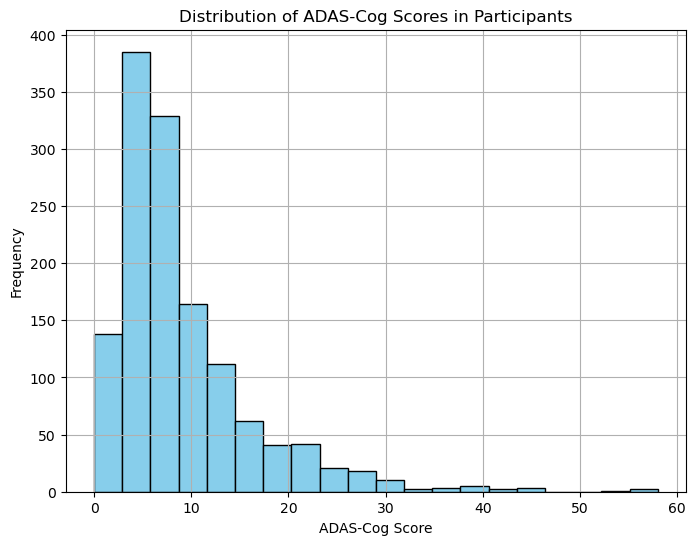

In [12]:
plt.figure(figsize=(8, 6))
plt.hist(df_all['TOTSCORE'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of ADAS-Cog Scores in Participants')
plt.xlabel('ADAS-Cog Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.axis('on')
# plt.savefig('../data/adas_score_dist_20.png')

plt.show()

In [6]:
# Define the number of buckets
n_buckets = 10

# Define the bins for splitting the column into buckets
bins = pd.cut(df_all['TOTSCORE'], bins=n_buckets, labels=False)

In [7]:
bins

0       0
1       1
2       0
3       0
4       1
       ..
1335    0
1336    2
1337    0
1338    3
1339    0
Name: TOTSCORE, Length: 1340, dtype: int64

In [14]:
buckets = {i: group for i, group in df_all.groupby(bins)}

for i in range(n_buckets):
    bucket = buckets.get(i)
    if bucket is not None:
        print(f"Bucket {i}:")
        print(bucket.shape)

Bucket 0:
(523, 5)
Bucket 1:
(493, 5)
Bucket 2:
(174, 5)
Bucket 3:
(83, 5)
Bucket 4:
(41, 5)
Bucket 5:
(10, 5)
Bucket 6:
(8, 5)
Bucket 7:
(5, 5)
Bucket 9:
(3, 5)


In [46]:
# Want a sample of size 50 - get 5 from each bucket

# sample_eq_df = None
# sample_n = 6

# for i in range(n_buckets):
#     bucket = buckets.get(i)
#     if bucket is not None:
#         f = bucket.shape[0]
#         bucket_n = sample_n if f > sample_n else f
        
#         random = bucket.sample(bucket_n)
#         sample_eq_df = pd.concat([sample_eq_df, random])

# sample_eq_df = sample_eq_df.reset_index(drop=True)
# sample_eq_df.shape

# Stratified

sample_df = None
total_sample = 0

for i in range(n_buckets):
    bucket = buckets.get(i)
    if bucket is not None:
        f = bucket.shape[0]
        sample_n = 1 if f * 0.1 < 1 else round(f * 0.1)
        print(sample_n)
        
        random = bucket.sample(sample_n)
        sample_df = pd.concat([sample_df, random])

sample_df = sample_df.reset_index(drop=True)
sample_df.shape

52
49
17
8
4
1
1
1
1


(134, 5)

In [ ]:
# sample_eq_df

In [54]:
dim_x = len(sample_df)
X_strat = []

for i, file in enumerate(sample_df['FC_DATA'].values):
    arr = loadmat(file)['ROI_activity'][:100, :] # get the first 100 regions
    fc = compute_correlation(arr)
    
    # Add noise along the diagonal
    noise_level = 0.0001  # Adjust this value as needed
    noise = np.random.randn(100) * noise_level
    fc_with_noise = fc + np.diag(noise)
    
    X_strat.append(fc_with_noise)
X_strat = np.array(X_strat)

Y_strat = sample_df['TOTSCORE']
print(Y_strat.shape)

X_strat_transposed = np.transpose(X_strat, (1, 2, 0))
print(X_strat_transposed.shape)

(134,)
(100, 100, 134)


In [ ]:
behav_pred_pos, behav_pred_neg = run_validate(X_strat_transposed, Y_strat, 'LOO')

In [57]:
# print(behav_pred_neg)

# print(np.array(Y_strat))


res = {
    'no_files': 134, 
    'noise': 0.0001, 
    'fc_gen_method': 'compute_correlation', 
    'pearson_r_pos': pearsonr(behav_pred_pos,Y_strat)[0], 
#     'pearson_r_neg': pearsonr(behav_pred_neg,Y_strat)[0],
    'spearman_rho_pos': spearmanr(behav_pred_pos,Y_strat)[0], 
#     'spearman_rho_neg': spearmanr(behav_pred_neg,Y_strat)[0], 
    'r2_pos': r2_score(behav_pred_pos,Y_strat), 
#     'r2_neg': r2_score(behav_pred_neg,Y_strat), 
    'mse_pos': mean_squared_error(behav_pred_pos,Y_strat),
#     'mse_neg': mean_squared_error(behav_pred_neg,Y_strat)
}
res

{'no_files': 134,
 'noise': 0.0001,
 'fc_gen_method': 'compute_correlation',
 'pearson_r_pos': 0.12093623752690097,
 'spearman_rho_pos': 0.11000444901836241,
 'r2_pos': -14.254429822692055,
 'mse_pos': 68.09069997573967}